In [1]:
from cdt.data import AcyclicGraphGenerator
import csv
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import pandas as pd
import networkx as nx
import datetime

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [10]:
graph_type = 'linear'
sample_size=50
nodes=10
parents_max=3

for i in range(25):
    generator = AcyclicGraphGenerator(graph_type, dag_type='erdos', npoints=sample_size, nodes=nodes, parents_max=parents_max)
    data, graph = generator.generate()
    generator.to_csv(f"graphs_10nodes_linear/{graph_type}_{nodes}nodes_{sample_size}samples_number_{i}") #this methods saves both the data, and ground truth graph

In [2]:
import CIGAN7

In [3]:
class CSVDataset(Dataset):
    def __init__(self, csv_path):
        data_np = np.loadtxt(csv_path, dtype=np.float32, delimiter=',', skiprows=1)
        self.col_names = next(csv.reader(open(csv_path), delimiter=','))
        self.data = torch.from_numpy(data_np)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample
    
    def get_col_names(self):
        return self.col_names

In [4]:
batch_size = 50
latent_dim = 100
hidden_dim = 200
lr=0.0002 #0.0002
epochs = 200
sample_interval = 400
batch_size = 50
PATH = 'datasets/sachs_data_noindex.csv'

In [5]:
dataset = CSVDataset(PATH)

In [6]:
def varsortability(X, W, tol=1e-9):
    """ Takes n x d data and a d x d adjaceny matrix,
    where the i,j-th entry corresponds to the edge weight for i->j,
    and returns a value indicating how well the variance order
    reflects the causal order. """
    E = W != 0
    Ek = E.copy()
    var = np.var(X, axis=0, keepdims=True)

    n_paths = 0
    n_correctly_ordered_paths = 0

    for _ in range(E.shape[0] - 1):
        n_paths += Ek.sum()
        n_correctly_ordered_paths += (Ek * var / var.T > 1 + tol).sum()
        n_correctly_ordered_paths += 1/2*(
            (Ek * var / var.T <= 1 + tol) *
            (Ek * var / var.T >  1 - tol)).sum()
        Ek = Ek.dot(E)

    return n_correctly_ordered_paths / n_paths

In [7]:
num_runs = 10
samples_per_run = 10
df_truth = pd.read_csv(PATH)
v_dict = {}
adjs = []
corr_avgs = []
samples = []
for run in range(num_runs):
  print(f'run {run} / {num_runs}')
  temp_model = CIGAN7.CIGAN(dataset,batch_size,latent_dim,hidden_dim,lr,epochs,sample_interval)
  temp_model.set_debug(True)
  temp_model.train()
  temp_adj = temp_model.get_adj_A().numpy()
  adjs.append(temp_adj)
  corrs = []
  for sample_run in range(samples_per_run):
    temp_sample = temp_model.get_synthetic_sample()
    samples.append(temp_sample)
    #-=-= pearson cor coef
    corr = temp_sample.corrwith(df_truth)
    corrs.append(corr)
    #-=-= varsortability
    v = varsortability(temp_sample.to_numpy(),temp_adj)
    v_dict[run] = v
  
    print(f'v: {v}')
  #-=-= more pearsin cor coef
  corr_avg = sum(corrs) / len(corrs)
  corr_avgs.append(corr_avg)
  print(f'corr: {corr_avg}')

run 0 / 10
Epoch 1: Generator loss=0.6913, Discriminator loss=0.9630
Epoch 2: Generator loss=0.8135, Discriminator loss=0.7378
Epoch 3: Generator loss=0.7030, Discriminator loss=0.6126
Epoch 4: Generator loss=0.7589, Discriminator loss=1.2762
Epoch 5: Generator loss=1.3991, Discriminator loss=0.4428
Epoch 6: Generator loss=1.3932, Discriminator loss=0.3950
Epoch 7: Generator loss=2.0290, Discriminator loss=0.2674
Epoch 8: Generator loss=1.6470, Discriminator loss=0.3423
Epoch 9: Generator loss=1.9117, Discriminator loss=0.2696
Epoch 10: Generator loss=2.3043, Discriminator loss=0.2509
Epoch 11: Generator loss=2.0469, Discriminator loss=0.3632
Epoch 12: Generator loss=1.0667, Discriminator loss=0.6475
Epoch 13: Generator loss=2.0235, Discriminator loss=0.3455
Epoch 14: Generator loss=2.7367, Discriminator loss=0.2896
Epoch 15: Generator loss=1.6176, Discriminator loss=0.2516
Epoch 16: Generator loss=2.9879, Discriminator loss=0.1293
Epoch 17: Generator loss=2.0101, Discriminator loss=0.

In [8]:
v_dict

{0: 0.44232804232804235,
 1: 0.4528301886792453,
 2: 0.4590325765054294,
 3: 0.45081967213114754,
 4: 0.4757804090419806,
 5: 0.46353646353646355,
 6: 0.45764854614412137,
 7: 0.4387019230769231,
 8: 0.32941176470588235,
 9: 0.45049954586739327}

In [1]:
adjs

NameError: name 'adjs' is not defined

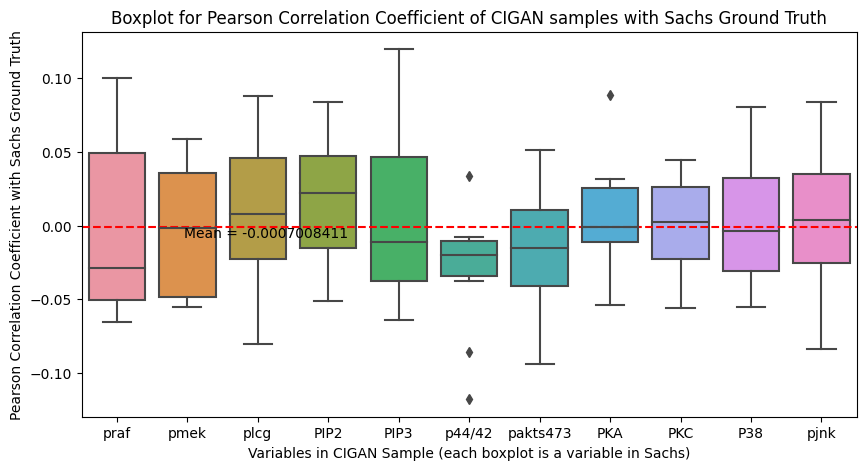

-0.0007008411271206799

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# for corr_avg in corr_avgs:
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     ax = sns.heatmap(corr_avg.to_frame(), cmap='coolwarm', annot=True)
#     plt.show()

big_corr_avg = sum(corr_avgs) / len(corr_avgs)
#box plot of each column 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
column1 = []
column2 = []
column3 = []
column4 = []
column5 = []
column6 = []
column7 = []
column8 = []
column9 = []
column10 = []
column11 = []
data = [column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11]
for corr_single in corr_avgs:
    for i in range(11):
        data[i].append(corr_single[i])

labels = corr_avgs[0].index.to_list()
ax = sns.boxplot(data=data)
ax.set_xticklabels(labels)
average = big_corr_avg.mean()
ax.axhline(average, color='r', linestyle='--')
ax.text(0.95, average, f"Mean = {average:.10f}", va='top', ha='left')
ax.set_xlabel('Variables in CIGAN Sample (each boxplot is a variable in Sachs)')
ax.set_ylabel('Pearson Correlation Coefficient with Sachs Ground Truth')
ax.set_title('Boxplot for Pearson Correlation Coefficient of CIGAN samples with Sachs Ground Truth')
plt.show()
average

In [45]:
corr_avgs[0].index.to_list()

['praf',
 'pmek',
 'plcg',
 'PIP2',
 'PIP3',
 'p44/42',
 'pakts473',
 'PKA',
 'PKC',
 'P38',
 'pjnk']

In [26]:
arr = pd.read_csv('/Users/joelhogg/Documents/disertation stuff/bench_datasets/EXPERIMENTATION/TARGETS/artificial_graphs/SHD_results.txt')

In [31]:
arr.iloc[:,1].to_numpy()

array([33., 37., 41., 28., 35., 40., 27., 33., 36., 43., 41., 43., 43.,
       32., 39., 29., 35., 31., 41., 39., 37., 39., 42.])

In [36]:
data = [[47, 59, 69], [50, 71, 69], [47, 56, 77], [40, 61, 66], [51, 66, 78], [37, 60, 69], [50, 78, 65], [48, 72, 75], [38, 66, 62], [55, 63, 71],
        [53, 65, 70], [49, 72, 61], [46, 53, 80], [39, 70, 70], [37, 63, 73], [41, 68, 64], [51, 63, 71], [43, 66, 69], [36, 58, 75], [49, 72, 65], [52, 68, 72]]

new_data = [33, 37, 41, 28, 35, 40, 27, 33, 36, 43, 41, 43, 43, 32, 39, 29, 35, 31, 41, 39, 37, 39, 42]

for idx, i in enumerate(new_data):
    if idx == len(data):
        break
    data[idx].append(i)
data

[[47, 59, 69, 33],
 [50, 71, 69, 37],
 [47, 56, 77, 41],
 [40, 61, 66, 28],
 [51, 66, 78, 35],
 [37, 60, 69, 40],
 [50, 78, 65, 27],
 [48, 72, 75, 33],
 [38, 66, 62, 36],
 [55, 63, 71, 43],
 [53, 65, 70, 41],
 [49, 72, 61, 43],
 [46, 53, 80, 43],
 [39, 70, 70, 32],
 [37, 63, 73, 39],
 [41, 68, 64, 29],
 [51, 63, 71, 35],
 [43, 66, 69, 31],
 [36, 58, 75, 41],
 [49, 72, 65, 39],
 [52, 68, 72, 37]]

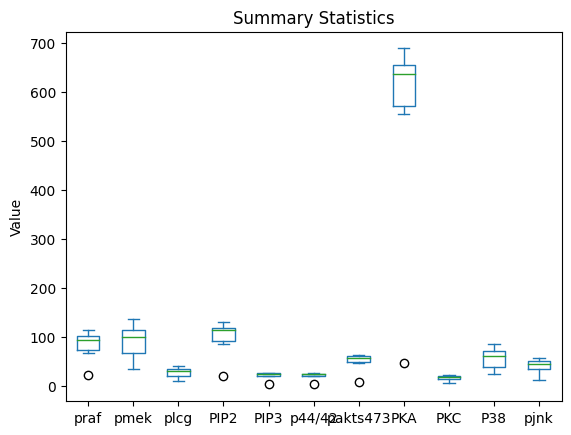

In [68]:
stats=(sum(samples)/len(samples)).describe()[1:-1]
fig, ax = plt.subplots()
stats.plot(kind='box', ax=ax)

# set the title and axis labels
ax.set_title('Summary Statistics')
ax.set_ylabel('Value')
plt.show()

In [61]:
df_truth.describe()

,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
count,7450.000000,7450.000000,7450.000000,7450.000000,7450.00000,7450.000000,7450.000000,7450.000000,7450.000000,7450.000000,7450.000000
mean,124.237897,145.686468,54.933060,151.284125,27.05365,26.642470,81.271299,625.779949,30.397738,135.022087,73.419219
std,247.762082,377.403216,174.037529,299.633083,43.09094,45.865959,137.891020,644.874579,92.960564,495.053705,215.867190
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,30.800000,16.700000,9.390000,18.300000,9.56000,8.510000,23.300000,276.000000,4.530000,19.300000,8.060000
50%,53.800000,26.700000,16.500000,53.300000,17.80000,17.200000,37.200000,449.000000,12.900000,30.500000,18.400000
75%,103.000000,64.400000,27.100000,172.000000,32.80000,32.200000,72.300000,750.000000,23.500000,49.600000,52.800000
max,4614.000000,7105.000000,6208.000000,9058.000000,1275.00000,2571.000000,3555.000000,8896.000000,1611.000000,7499.000000,4740.000000


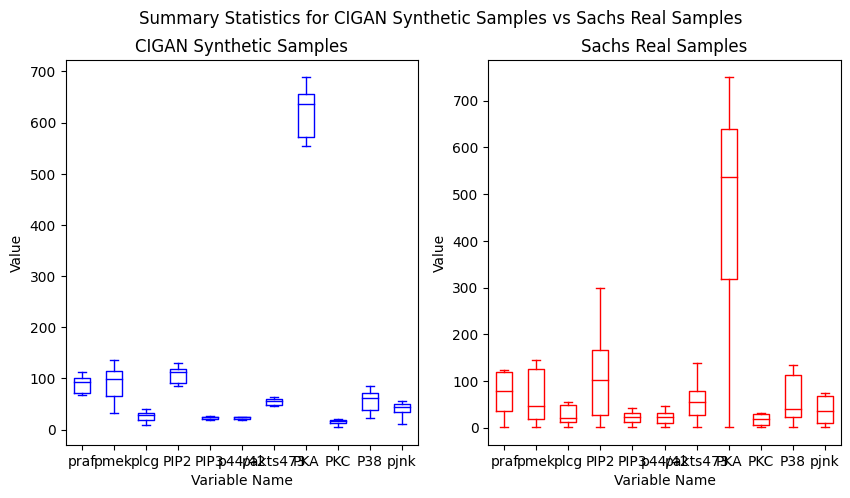

In [92]:
synth_stats=(sum(samples)/len(samples)).describe()[1:-1]
real_stats=df_truth.describe()[1:-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
synth_stats.plot(kind='box', color='blue', ax=ax1,showfliers = False)
real_stats.plot(kind='box', color='red', ax=ax2,showfliers = False)

# set the title and axis labels
ax1.set_title('CIGAN Synthetic Samples')
ax1.set_ylabel('Value')
ax1.set_xlabel('Variable Name')

ax2.set_title('Sachs Real Samples')
ax2.set_ylabel('Value')
ax2.set_xlabel('Variable Name')

#set the plot title:
plt.suptitle('Summary Statistics for CIGAN Synthetic Samples vs Sachs Real Samples')

plt.show()

In [70]:
df_truth.describe()[1:-1]

,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
mean,124.237897,145.686468,54.933060,151.284125,27.05365,26.642470,81.271299,625.779949,30.397738,135.022087,73.419219
std,247.762082,377.403216,174.037529,299.633083,43.09094,45.865959,137.891020,644.874579,92.960564,495.053705,215.867190
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,30.800000,16.700000,9.390000,18.300000,9.56000,8.510000,23.300000,276.000000,4.530000,19.300000,8.060000
50%,53.800000,26.700000,16.500000,53.300000,17.80000,17.200000,37.200000,449.000000,12.900000,30.500000,18.400000
75%,103.000000,64.400000,27.100000,172.000000,32.80000,32.200000,72.300000,750.000000,23.500000,49.600000,52.800000


In [93]:
df_truth.describe().to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n & praf & pmek & plcg & PIP2 & PIP3 & p44/42 & pakts473 & PKA & PKC & P38 & pjnk \\\\\n\\midrule\ncount & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 & 7450.000000 \\\\\nmean & 124.237897 & 145.686468 & 54.933060 & 151.284125 & 27.053650 & 26.642470 & 81.271299 & 625.779949 & 30.397738 & 135.022087 & 73.419219 \\\\\nstd & 247.762082 & 377.403216 & 174.037529 & 299.633083 & 43.090940 & 45.865959 & 137.891020 & 644.874579 & 92.960564 & 495.053705 & 215.867190 \\\\\nmin & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 \\\\\n25% & 30.800000 & 16.700000 & 9.390000 & 18.300000 & 9.560000 & 8.510000 & 23.300000 & 276.000000 & 4.530000 & 19.300000 & 8.060000 \\\\\n50% & 53.800000 & 26.700000 & 16.500000 & 53.300000 & 17.800000 & 17.200000 & 37.200000 & 449.000000 & 12.900000 & 30.500000 

In [94]:
((sum(samples)/len(samples)).describe()).to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n & praf & pmek & plcg & PIP2 & PIP3 & p44/42 & pakts473 & PKA & PKC & P38 & pjnk \\\\\n\\midrule\ncount & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 & 50.000000 \\\\\nmean & 102.225105 & 114.895897 & 33.426468 & 118.671188 & 24.903570 & 24.358616 & 59.515678 & 657.327820 & 18.861446 & 71.556313 & 50.380733 \\\\\nstd & 21.149761 & 33.097664 & 8.942586 & 18.997259 & 2.788921 & 2.305845 & 7.730553 & 46.687756 & 4.663389 & 23.248390 & 11.684608 \\\\\nmin & 67.241379 & 59.165680 & 16.700653 & 84.574295 & 18.837490 & 19.591494 & 46.665947 & 553.776978 & 11.968894 & 33.921394 & 31.801443 \\\\\n25% & 86.246017 & 87.870049 & 27.147010 & 107.085484 & 22.662432 & 23.101337 & 53.890884 & 625.238556 & 15.310949 & 53.911802 & 41.933522 \\\\\n50% & 99.164806 & 109.705906 & 31.585348 & 118.244991 & 25.316066 & 24.577830 & 59.693651 & 649.215271 & 18.595778 & 68.161121 & 47.087730 \\\\

In [98]:
list(v_dict.values())

[0.44232804232804235,
 0.4528301886792453,
 0.4590325765054294,
 0.45081967213114754,
 0.4757804090419806,
 0.46353646353646355,
 0.45764854614412137,
 0.4387019230769231,
 0.32941176470588235,
 0.45049954586739327]

FixedFormatter should only be used together with FixedLocator


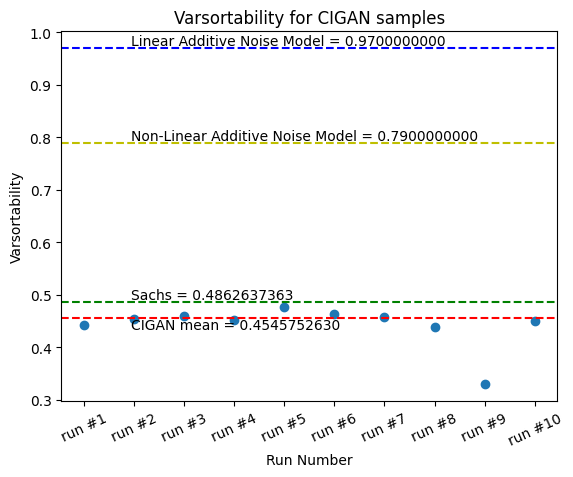

In [119]:
fig, ax = plt.subplots()
runs = ['run #1', 'run #2', 'run #3', 'run #4', 'run #5', 'run #6', 'run #7', 'run #8', 'run #9', 'run #10']
ax.scatter(runs,list(v_dict.values()))
remove_anomly = list(v_dict.values())
del remove_anomly[8]
average = sum(remove_anomly) / (len(list(v_dict.values()))-1)
ax.axhline(average, color='r', linestyle='--')
ax.text(0.95, average, f"CIGAN mean = {average:.10f}", va='top', ha='left')
sachs = 0.48626373626373626
ax.axhline(sachs, color='g', linestyle='--')
ax.text(0.95, sachs, f"Sachs = {sachs:.10f}", va='bottom', ha='left')
er1_linear = 0.97
ax.axhline(er1_linear, color='b', linestyle='--') #gumbel noise, from BEWARE in appendix, ER1
ax.text(0.95, er1_linear, f"Linear Additive Noise Model = {er1_linear:.10f}", va='bottom', ha='left')
non_linear = 0.79 #MLP type, ER1
ax.axhline(non_linear, color='y', linestyle='--')
ax.text(0.95, non_linear, f"Non-Linear Additive Noise Model = {non_linear:.10f}", va='bottom', ha='left')
ax.set_xlabel('Run Number')
ax.set_ylabel('Varsortability')
ax.set_title('Varsortability for CIGAN samples')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

plt.show()

In [130]:
from scipy.stats import ks_2samp
from scipy.stats import kstest

In [125]:
truth = df_truth.iloc[:50,:]

In [124]:
pred = samples[0]

In [128]:
pred_col1 = pred.iloc[:,0]
truth_col1 = truth.iloc[:,0]

In [136]:
ks_2samp(pred,truth)

ValueError: object too deep for desired array

In [132]:
kstest(pred_col1,'norm')

KstestResult(statistic=0.98, pvalue=2.251799813685348e-85)

K2 test for praf: KstestResult(statistic=0.22, pvalue=0.17858668181221732)


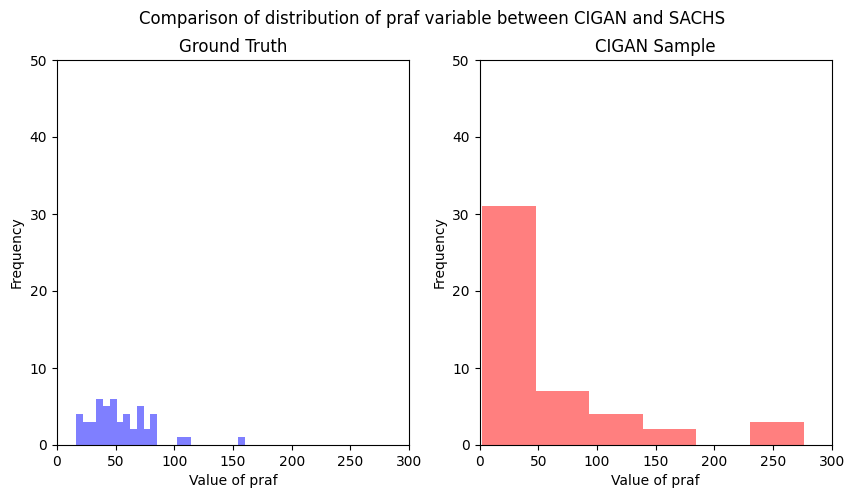

K2 test for pmek: KstestResult(statistic=0.26, pvalue=0.06779471096995852)


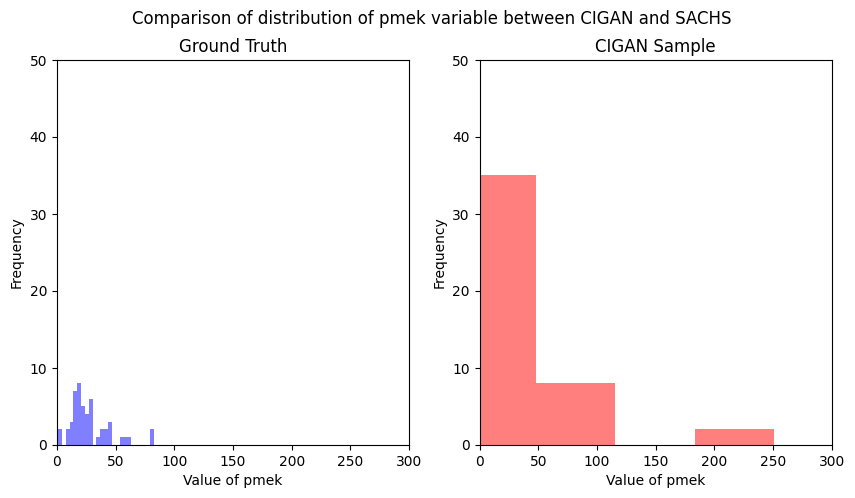

K2 test for plcg: KstestResult(statistic=0.36, pvalue=0.002834980581320342)


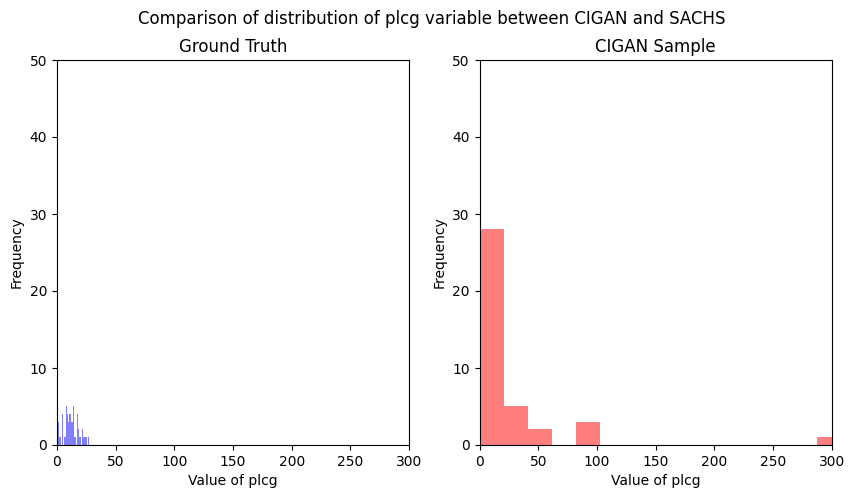

K2 test for PIP2: KstestResult(statistic=0.3, pvalue=0.02170784069014051)


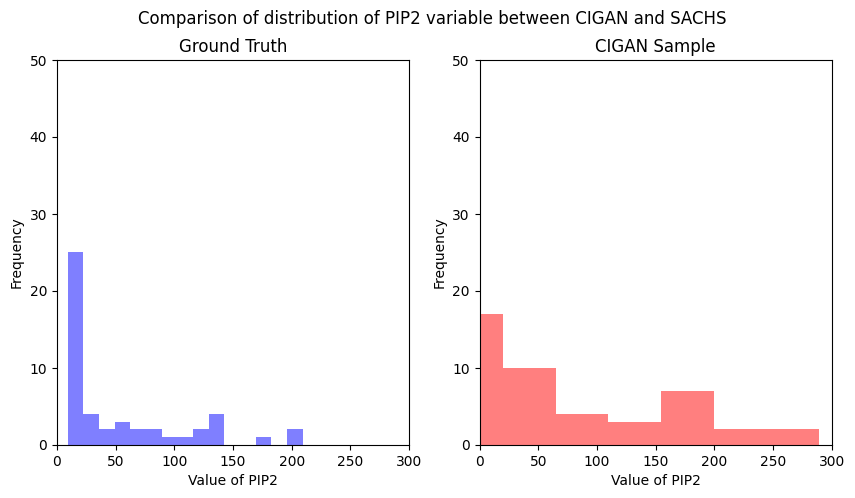

K2 test for PIP3: KstestResult(statistic=0.2, pvalue=0.2719135601522248)


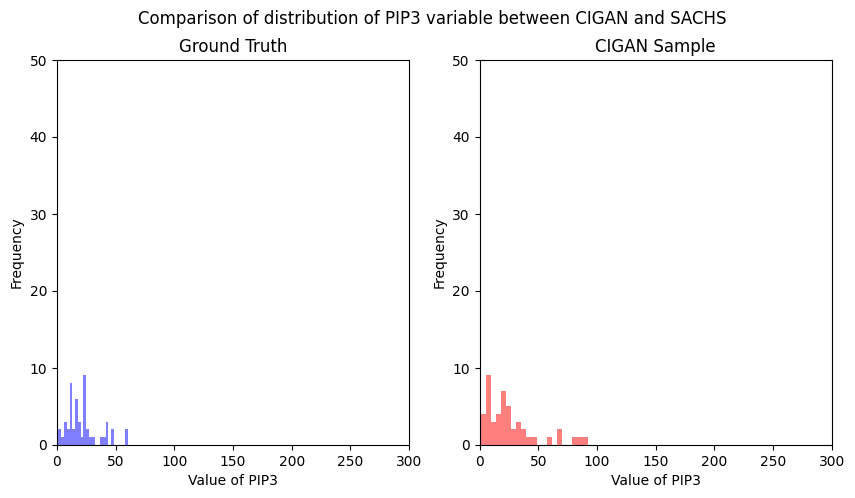

K2 test for p44/42: KstestResult(statistic=0.22, pvalue=0.17858668181221732)


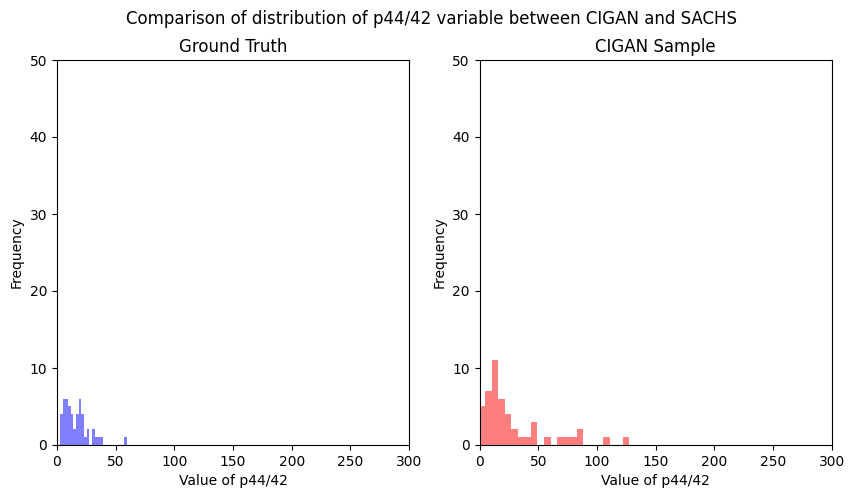

K2 test for pakts473: KstestResult(statistic=0.3, pvalue=0.02170784069014051)


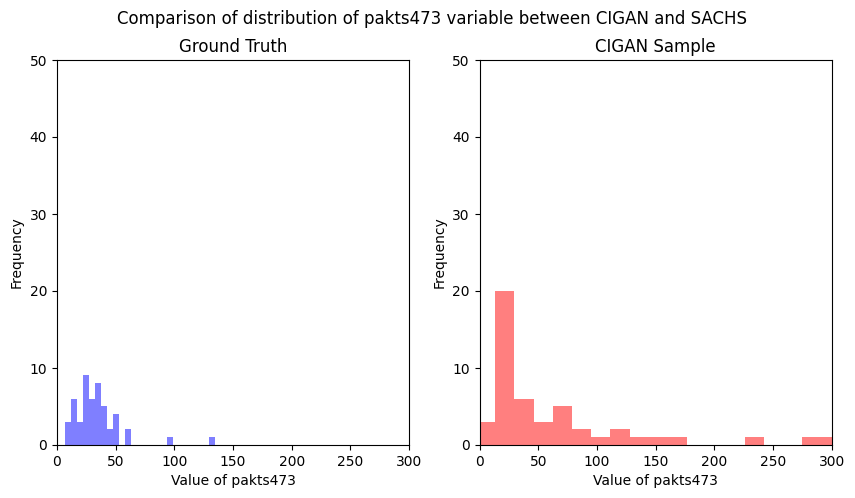

K2 test for PKA: KstestResult(statistic=0.36, pvalue=0.002834980581320342)


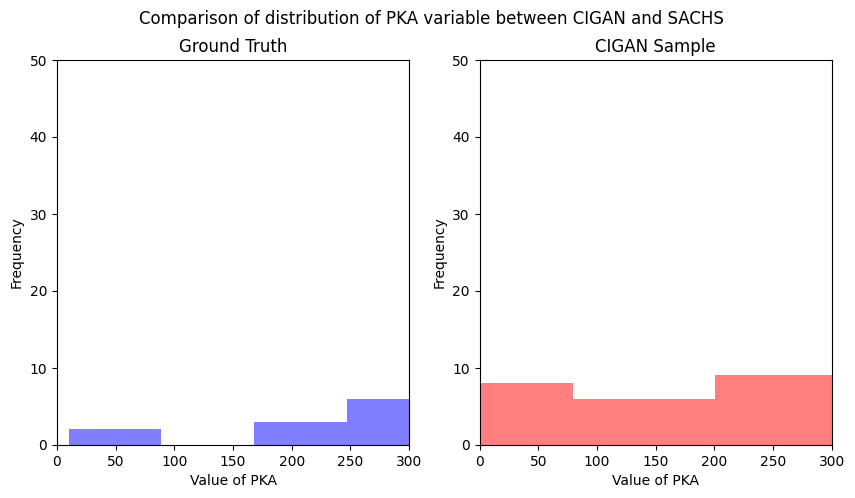

K2 test for PKC: KstestResult(statistic=0.42, pvalue=0.0002460240344273171)


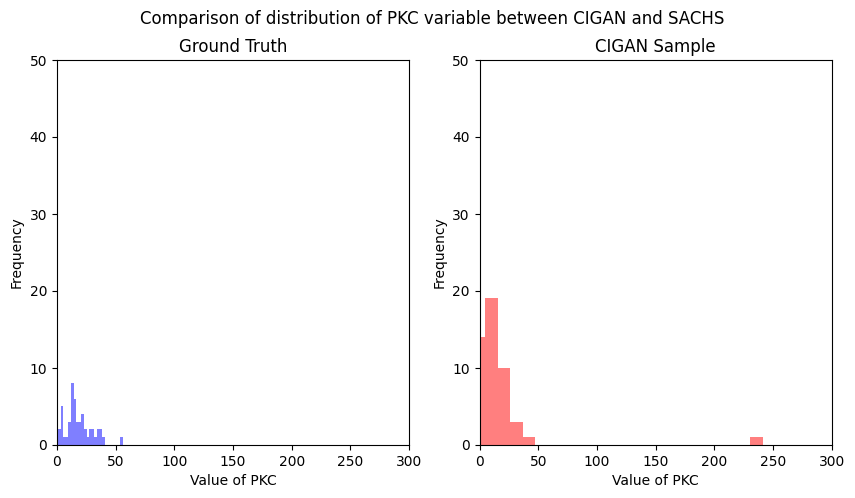

K2 test for P38: KstestResult(statistic=0.36, pvalue=0.002834980581320342)


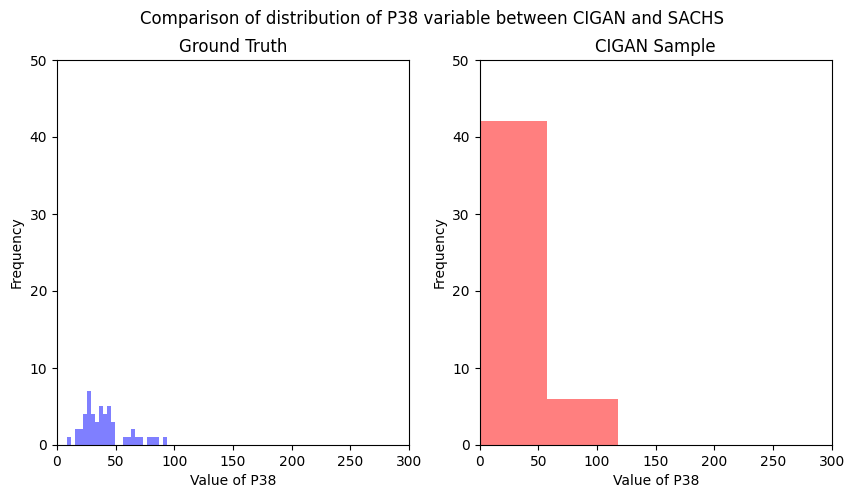

K2 test for pjnk: KstestResult(statistic=0.16, pvalue=0.5486851446031328)


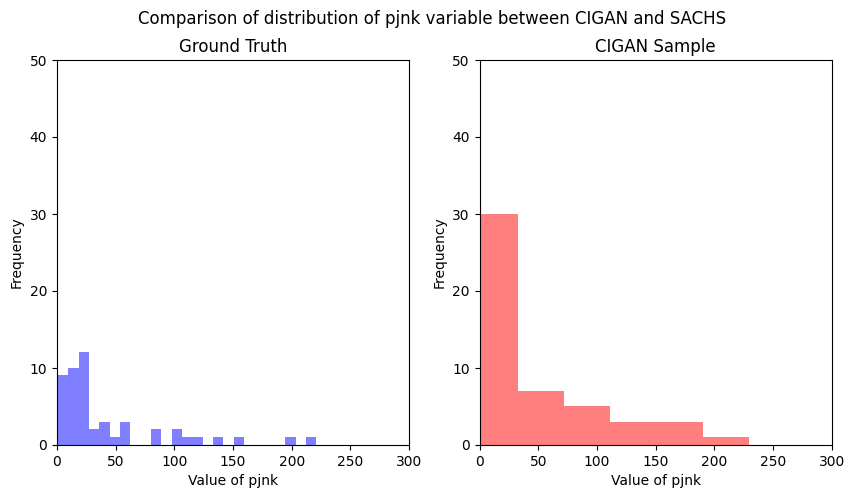

In [135]:
BINS = 25
XLIM = 300
YLIM = 50
df_pred = samples[0]
for col in truth.columns:
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].hist(truth[col], bins=BINS, color='blue', alpha=0.5)
  axs[0].set_xlabel(f'Value of {col}')
  axs[0].set_ylabel(f'Frequency')
  axs[0].set_title('Ground Truth')
  axs[0].set_xlim(0,XLIM)
  axs[0].set_ylim(0,YLIM)

  axs[1].hist(pred[col], bins=BINS, color='red', alpha=0.5)
  axs[1].set_title('CIGAN Sample')
  axs[1].set_xlabel(f'Value of {col}')
  axs[1].set_ylabel(f'Frequency')
  axs[1].set_xlim(0,XLIM)
  axs[1].set_ylim(0,YLIM)

  print(f'K2 test for {col}: {ks_2samp(pred[col],truth[col])}')

  fig.suptitle(f'Comparison of distribution of {col} variable between CIGAN and SACHS')
  plt.show()

In [142]:
with open('writehere.txt','r+') as f:
  f.write(df_truth.iloc[:10,:].to_latex())


In [140]:
df_truth

,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.20,8.82,18.30,58.80,6.61,17.00,414.0,17.00,44.90,40.00
1,35.9,16.50,12.30,16.80,8.13,18.60,32.50,352.0,3.37,16.50,61.50
2,59.4,44.10,14.60,10.20,13.00,14.90,32.50,403.0,11.40,31.90,19.50
3,73.0,82.80,23.10,13.50,1.29,5.83,11.80,528.0,13.70,28.60,23.10
4,33.7,19.80,5.19,9.73,24.80,21.10,46.10,305.0,4.66,25.70,81.30
...,...,...,...,...,...,...,...,...,...,...,...
7445,59.9,1.01,41.40,311.00,93.90,9.39,12.30,294.0,1.00,445.00,2.19
7446,14.3,1.76,32.20,227.00,19.60,18.10,29.40,737.0,1.00,7.17,2.44
7447,28.4,2.11,1.00,6.10,30.50,18.60,22.10,269.0,21.10,2690.00,5.99
7448,44.1,1.89,30.00,39.60,21.10,2.50,9.22,279.0,3.65,308.00,7.91
